In [5]:
import os
import time
import csv
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

# Corrected directory paths

normal_dir = r"C:\Users\ahmad\.cache\kagglehub\datasets\obulisainaren\multi-cancer\versions\3\Multi Cancer\Multi Cancer\Oral Cancer\oral_normal"
tumor_dir  = r"C:\Users\ahmad\.cache\kagglehub\datasets\obulisainaren\multi-cancer\versions\3\Multi Cancer\Multi Cancer\Oral Cancer\oral_scc"

# Constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
MAX_IMAGES = 7000
CSV_PATH = 'model_results.csv'
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)  # Grayscale input

# Initialize CSV for results, now with AUC column
def init_csv():
    with open(CSV_PATH, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'Model',
            'Training_Time_s',
            'Accuracy',
            'AUC',
            'Loss',
            'Confusion_Matrix',
            'Notes'
        ])

# Load and preprocess grayscale images
# def load_data(max_images=None):
#     imgs, labels = [], []
#     for folder, label in [(normal_dir, 0), (tumor_dir, 1)]:
#         count = 0
#         for fname in os.listdir(folder):
#             if max_images and count >= max_images:
#                 break
#             if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
#                 img_path = os.path.join(folder, fname)
#                 img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#                 if img is not None:
#                     img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
#                     img = img.astype(np.float32)
#                     imgs.append(img)
#                     labels.append(label)
#                     count += 1
#     imgs = np.array(imgs)
#     return np.expand_dims(imgs, axis=-1), np.array(labels)

def load_data(max_images=None):
    imgs, labels = [], []
    for folder, label in [(normal_dir, 0), (tumor_dir, 1)]:
        count = 0
        for fname in os.listdir(folder):
            if max_images and count >= max_images:
                break
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder, fname)
                # Read color image (BGR), then convert to RGB:
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
                    imgs.append(img.astype(np.float32))
                    labels.append(label)
                    count += 1
    return np.array(imgs), np.array(labels)
    
# Model builders
# def build_cnn(input_shape):
#     model = models.Sequential([
#         layers.Rescaling(1./255, input_shape=input_shape),
#         layers.Conv2D(32, (3,3), activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(64, (3,3), activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(128, (3,3), activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Flatten(),
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

def build_cnn(input_shape):
    model = models.Sequential([
        # now rescale 3-channel
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
def build_autoencoder(input_shape):
    # Encoder
    encoder = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2,2, padding='same'),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2,2, padding='same')
    ])

    # Decoder
    decoder = models.Sequential([
        layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(1, 3, activation='sigmoid', padding='same')
    ])

    # Autoencoder
    inp = layers.Input(shape=input_shape)
    code = encoder(inp)
    recon = decoder(code)
    autoencoder = models.Model(inp, recon)
    autoencoder.compile(optimizer='adam', loss='mse')

    # --- NEW: compute flat dimension for classifier input ---
    flat_dim = np.prod(encoder.output_shape[1:])  # e.g. 56*56*64 = 200704

    # Classifier head: now expects a flat vector of length flat_dim
    classifier = models.Sequential([
        layers.Input(shape=(flat_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return autoencoder, encoder, classifier


# def build_resnet(input_shape):
#     inputs = layers.Input(shape=input_shape)
#     # Gray→RGB
#     x = layers.Lambda(lambda img: tf.repeat(img, 3, axis=-1))(inputs)
#     x = layers.Lambda(preprocess_input)(x)
#     base = ResNet50(include_top=False, weights='imagenet', input_tensor=x)
#     base.trainable = False
#     x = layers.GlobalAveragePooling2D()(base.output)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)
#     model = models.Model(inputs, outputs)
#     model.compile(optimizer='adam', loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

def build_resnet(input_shape):
    inputs = layers.Input(shape=input_shape)
    # No need to repeat channels—already 3-channel RGB
    x = layers.Lambda(preprocess_input)(inputs)
    base = ResNet50(include_top=False,
                    weights='imagenet',
                    input_tensor=x)
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Early stopping callback (used everywhere)
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [6]:
import time
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, confusion_matrix

# (Assume that the following functions/objects are defined elsewhere in your codebase:
#   init_csv, load_data, build_cnn, build_autoencoder, build_resnet,
#   datagen, INPUT_SHAPE, MAX_IMAGES, BATCH_SIZE, EPOCHS, early_stopping, CSV_PATH
# )


def plot_results(history, y_true, y_pred_prob, model_name="Model"):
    # Plot accuracy and loss curves
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print(f"AUC: {auc:.4f}")

    # Confusion Matrix
    y_pred = (y_pred_prob > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


def get_data_splits(max_images=MAX_IMAGES, input_shape=INPUT_SHAPE):
    """
    Load all images (X) and labels (y), then split into train/val/test (70/15/15).
    Returns: X_train, y_train, X_val, y_val, X_test, y_test
    """
    print("Loading images...")
    X, y = load_data(max_images)
    print(f"Loaded {len(X)} images. Shape: {X.shape}")

    # 70/15/15 split
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
    )

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    return X_train, y_train, X_val, y_val, X_test, y_test

In [24]:
def run_cnn_experiment(augment=False):
    init_csv()
    X_train, y_train, X_val, y_val, X_test, y_test = get_data_splits()

    print(f"\n--- Training CNN (augment={augment}) ---")
    start_t = time.time()
    model = build_cnn(INPUT_SHAPE)

    if augment:
        gen = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
        history = model.fit(
        gen,
        steps_per_epoch=len(X_train)//BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1    )
    else:
        history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1)

    y_prob = model.predict(X_test, verbose=0).flatten()
    elapsed = time.time() - start_t
    y_pred = (y_prob > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    # Append to CSV
    with open(CSV_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "CNN",
            f"{elapsed:.2f}",
            f"{acc:.4f}",
            f"{auc:.4f}",
            f"{loss:.4f}",
            str(cm.tolist()),
            f"Epochs: {EPOCHS}"
        ])

    print("CNN Results:")
    print(f"  Time: {elapsed:.1f}s, Acc: {acc:.4f}, AUC: {auc:.4f}, Loss: {loss:.4f}")
    print(f"  Confusion Matrix:\n{cm}")
    plot_results(history, y_test, y_prob, model_name="CNN")

Experiment started at: Sat Jun  7 11:23:50 2025
Loading images...
Loaded 10000 images. Shape: (10000, 224, 224, 1)
Train: 7000, Val: 1500, Test: 1500

--- Training CNN (augment=False) ---


C:\Users\ahmad\miniconda3\envs\tf-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 59s 259ms/step - accuracy: 0.8425 - loss: 0.3295 - val_accuracy: 0.9980 - val_loss: 0.0090
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 264ms/step - accuracy: 0.9892 - loss: 0.0296 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 59s 270ms/step - accuracy: 0.9960 - loss: 0.0092 - val_accuracy: 0.9993 - val_loss: 0.0020
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 410ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.9993 - val_loss: 0.0013
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 117s 534ms/step - accuracy: 0.9969 - loss: 0.0087 - val_accuracy: 0.9980 - val_loss: 0.0041
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 112s 512ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 3.3656e-04
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 116s 530ms/step - accuracy: 0.9969 - loss: 0.0100 - val_accuracy: 0.9987 - val_loss: 0.0041
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - accuracy: 0.9987 -

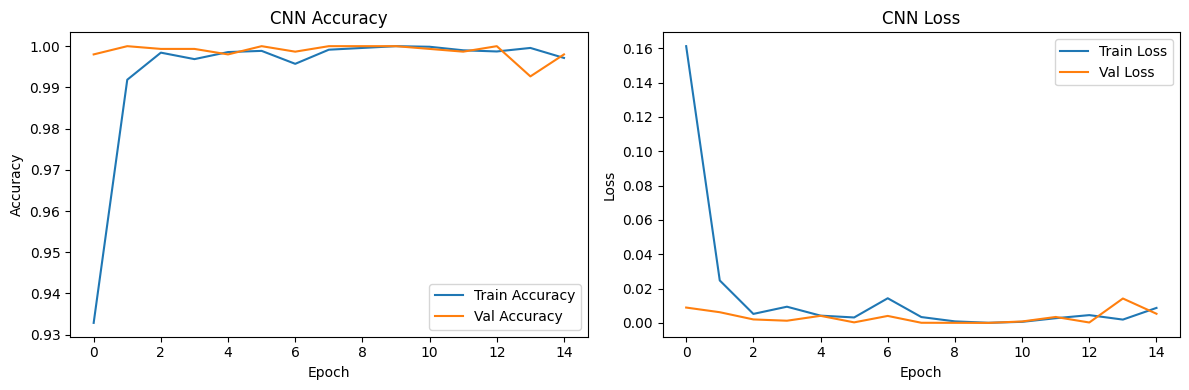

AUC: 1.0000


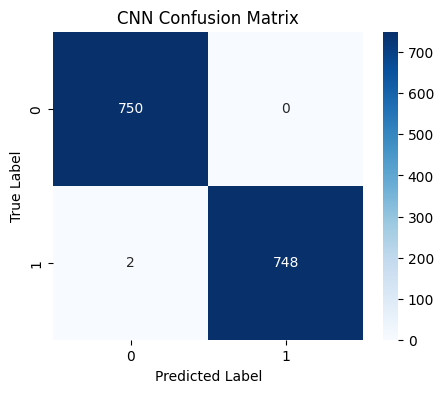

Loading images...
Loaded 10000 images. Shape: (10000, 224, 224, 1)
Train: 7000, Val: 1500, Test: 1500

--- Training CNN (augment=True) ---


C:\Users\ahmad\miniconda3\envs\tf-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ahmad\miniconda3\envs\tf-env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 128s 547ms/step - accuracy: 0.6831 - loss: 0.5985 - val_accuracy: 0.7813 - val_loss: 0.4129
Epoch 2/30
  1/218 ━━━━━━━━━━━━━━━━━━━━ 1:51 514ms/step - accuracy: 0.7812 - loss: 0.5529

C:\Users\ahmad\miniconda3\envs\tf-env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7812 - loss: 0.5529 - val_accuracy: 0.7993 - val_loss: 0.4084
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 115s 526ms/step - accuracy: 0.8144 - loss: 0.4234 - val_accuracy: 0.7060 - val_loss: 1.3232
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8750 - loss: 0.2388 - val_accuracy: 0.7013 - val_loss: 1.3716
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 116s 532ms/step - accuracy: 0.8845 - loss: 0.2723 - val_accuracy: 0.6560 - val_loss: 1.7878
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9375 - loss: 0.2361 - val_accuracy: 0.6860 - val_loss: 1.5447
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 118s 540ms/step - accuracy: 0.9180 - loss: 0.2018 - val_accuracy: 0.6480 - val_loss: 1.7083
CNN Results:
  Time: 507.9s, Acc: 0.8053, AUC: 0.9162, Loss: 0.3944
  Confusion Matrix:
[[673  77]
 [215 535]]


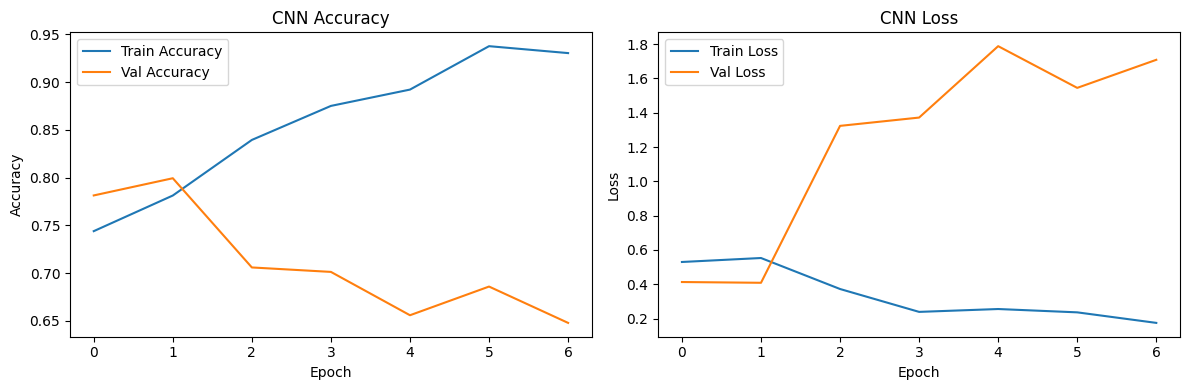

AUC: 0.9162


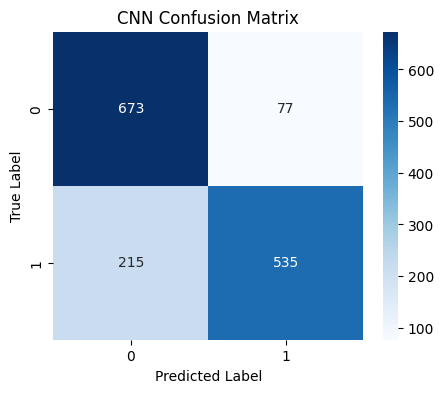


Experiment completed. Results saved to model_results.csv


In [25]:
if __name__ == "__main__":
    print("Experiment started at:", time.ctime())
    run_cnn_experiment(augment=False)
    run_cnn_experiment(augment=True)

    print("\nExperiment completed. Results saved to", CSV_PATH)

Loading images...
Loaded 10000 images. Shape: (10000, 224, 224, 1)
Train: 7000, Val: 1500, Test: 1500


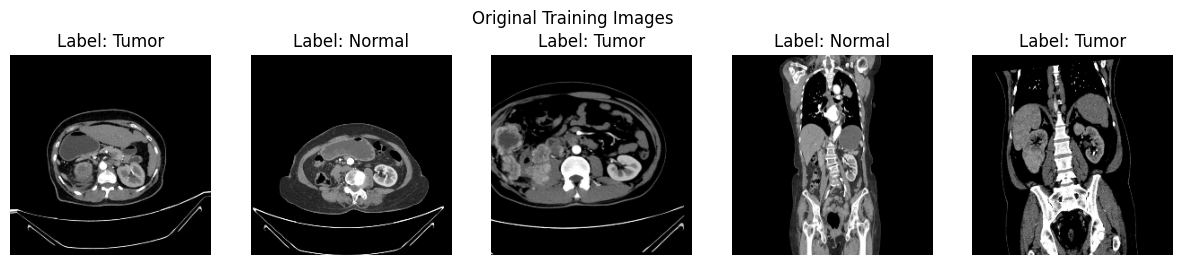

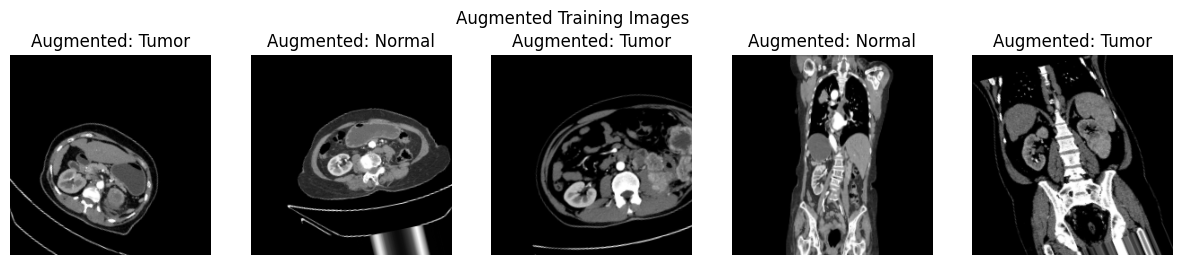

In [20]:
def show_original_images(X_train, y_train, indices):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img = X_train[idx].squeeze()
        label = y_train[idx]
        plt.subplot(1, len(indices), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {'Tumor' if label==1 else 'Normal'}")
        plt.axis('off')
    plt.suptitle("Original Training Images")
    plt.show()


def show_augmented_images(X_train, y_train, indices):
    # Select the same images by index and generate a small batch manually
    selected_X = X_train[indices]
    selected_y = y_train[indices]
    gen = datagen.flow(selected_X, selected_y, batch_size=len(indices), shuffle=False)

    X_batch, y_batch = next(gen)

    plt.figure(figsize=(15, 3))
    for i in range(len(indices)):
        img = X_batch[i].squeeze()
        label = y_batch[i]
        plt.subplot(1, len(indices), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Augmented: {'Tumor' if label==1 else 'Normal'}")
        plt.axis('off')
    plt.suptitle("Augmented Training Images")
    plt.show()

    
# Load data once
X_train, y_train, X_val, y_val, X_test, y_test = get_data_splits()

# Pick some fixed indices (e.g., 5 random samples)
np.random.seed(42)
indices_to_plot = np.random.choice(len(X_train), size=5, replace=False)

# Show original and augmented versions of the same samples
show_original_images(X_train, y_train, indices_to_plot)
show_augmented_images(X_train, y_train, indices_to_plot)


In [7]:
def run_autoencoder_experiment(augment=False):
    init_csv()
    X_train, y_train, X_val, y_val, X_test, y_test = get_data_splits()
    n = 8
    orig = X_test[:n]
    autoenc, encoder, classifier = build_autoencoder(INPUT_SHAPE)
    recon = autoenc.predict(orig)
    plt.figure(figsize=(16, 4))
    for i in range(n):
        # original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].squeeze(), cmap='gray')
        plt.axis('off')
        # reconstructed
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(recon[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle('Top: original images Bottom: reconstructions')
       
    
    print(f"\n--- Training Autoencoder (augment={augment}) ---")
    start_t = time.time()
   

    # 1) Pretrain autoencoder
    if augment:
        ae_gen = datagen.flow(X_train, X_train, batch_size=BATCH_SIZE)
        autoenc.fit(
            ae_gen,
            steps_per_epoch=len(X_train)//BATCH_SIZE,
            epochs=20,
            validation_data=(X_val, X_val),
            callbacks=[early_stopping],
            verbose=1
        )
    else:
        autoenc.fit(
            X_train, X_train,
            epochs=20,
            validation_data=(X_val, X_val),
            callbacks=[early_stopping],
            verbose=1
        )

    # 2) Encode
    
    def encode_and_flatten(data):
        feats = encoder.predict(data, verbose=0)
        return feats.reshape(feats.shape[0], -1)

    X_train_enc = encode_and_flatten(X_train)
    X_val_enc   = encode_and_flatten(X_val)
    X_test_enc  = encode_and_flatten(X_test)

    # 3) Train classifier (no augmentation on features)
    history = classifier.fit(
        X_train_enc, y_train,
        epochs=20,
        validation_data=(X_val_enc, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    # 3) Train the classifier on the encoded features
    classifier.fit(
        X_train_enc, y_train,
        epochs=20,
        validation_data=(X_val_enc, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # 4) Evaluate
    y_prob = classifier.predict(X_test_enc, verbose=0).flatten()
    elapsed = time.time() - start_t
    y_pred = (y_prob > 0.5).astype(int)
    plot_results(history, y_test, y_prob, model_name="CNN + autoencoder")

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    # Append to CSV
    with open(CSV_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "Autoencoder",
            f"{elapsed:.2f}",
            f"{acc:.4f}",
            f"{auc:.4f}",
            f"{loss:.4f}",
            str(cm.tolist()),
            f"Epochs: 20 (AE) + 20 (Classifier)"
        ])

    print("Autoencoder + Classifier Results:")
    print(f"  Time: {elapsed:.1f}s, Acc: {acc:.4f}, AUC: {auc:.4f}, Loss: {loss:.4f}")
    print(f"  Confusion Matrix:\n{cm}")

Experiment started at: Sun Jun  8 09:43:49 2025
Loading images...
Loaded 10000 images. Shape: (10000, 224, 224, 1)
Train: 7000, Val: 1500, Test: 1500


C:\Users\ahmad\miniconda3\envs\tf-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step

--- Training Autoencoder (augment=False) ---
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 102s 454ms/step - loss: 5699.6182 - val_loss: 5557.4473
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 449ms/step - loss: 5634.4683 - val_loss: 5557.1284
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 448ms/step - loss: 5689.9468 - val_loss: 5557.1055
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 99s 451ms/step - loss: 5686.0205 - val_loss: 5557.0991
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 448ms/step - loss: 5653.9863 - val_loss: 5557.0967
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 448ms/step - loss: 5680.3721 - val_loss: 5557.0952
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 448ms/step - loss: 5645.2476 - val_loss: 5557.0928
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 448ms/step - loss: 5632.4111 - val_loss: 5557.0918
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 448ms/step - loss: 5607.9438 - val_loss: 5557.0908
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 449ms/step - l

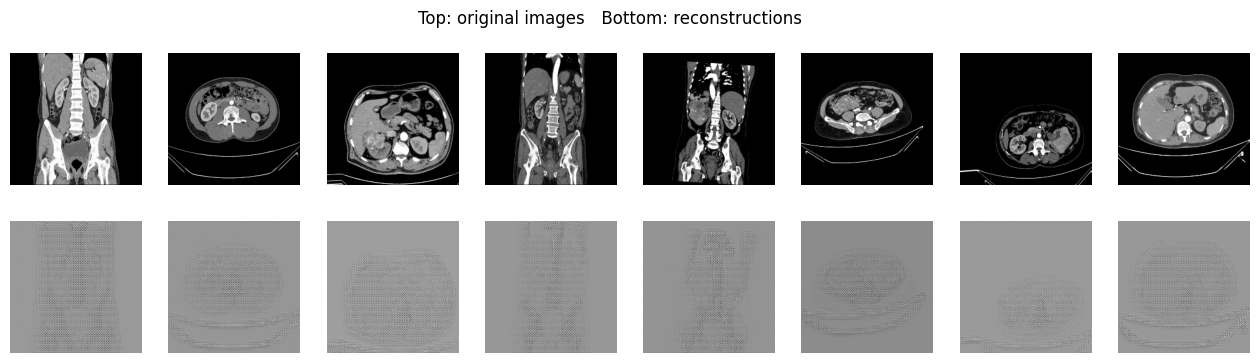

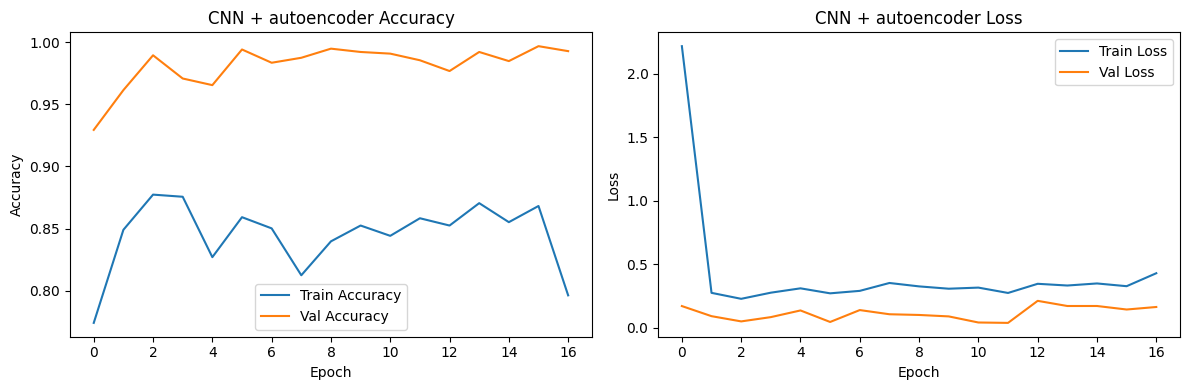

AUC: 0.9998


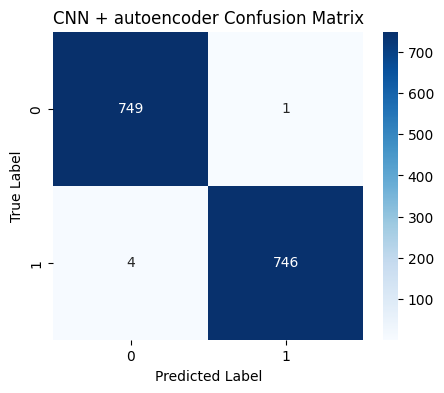

Autoencoder + Classifier Results:
  Time: 2653.0s, Acc: 0.9967, AUC: 0.9998, Loss: 0.0175
  Confusion Matrix:
[[749   1]
 [  4 746]]

Experiment completed. Results saved to model_results.csv


In [8]:
if __name__ == "__main__":
    print("Experiment started at:", time.ctime())
    run_autoencoder_experiment()
    print("\nExperiment completed. Results saved to", CSV_PATH)

In [7]:
def run_resnet_experiment():
    """
    Train a ResNet model (with optional augmentation) on the dataset,
    then evaluate and log metrics to CSV.
    """
    init_csv()  # If CSV already has headers from a previous run, skip this line.
    X_train, y_train, X_val, y_val, X_test, y_test = get_data_splits()

    print("\n--- Training ResNet ---")
    start_t = time.time()

    model = build_resnet(INPUT_SHAPE)
   
    history= model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1)

    y_prob = model.predict(X_test, verbose=0).flatten()
    elapsed = time.time() - start_t
    y_pred = (y_prob > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    # Append to CSV
    with open(CSV_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "ResNet",
            f"{elapsed:.2f}",
            f"{acc:.4f}",
            f"{auc:.4f}",
            f"{loss:.4f}",
            str(cm.tolist()),
            f"Epochs: {EPOCHS}"
        ])

    print("ResNet Results:")
    print(f"  Time: {elapsed:.1f}s, Acc: {acc:.4f}, AUC: {auc:.4f}, Loss: {loss:.4f}")
    print(f"  Confusion Matrix:\n{cm}")
    plot_results(history, y_test, y_prob, model_name="resnet")

import seaborn as sns

Experiment started at: Sun Jun  8 13:22:17 2025
Loading images...
Loaded 10002 images. Shape: (10002, 224, 224, 3)
Train: 7001, Val: 1500, Test: 1501

--- Training ResNet ---

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 200s 880ms/step - accuracy: 0.7124 - loss: 0.5872 - val_accuracy: 0.8587 - val_loss: 0.3460
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 189s 864ms/step - accuracy: 0.8387 - loss: 0.3605 - val_accuracy: 0.8747 - val_loss: 0.2846
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 188s 858ms/step - accuracy: 0.8687 - loss: 0.3007 - val_accuracy: 0.8893 - val_loss: 0.2415
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 188s 857ms/step - accuracy: 0.8827 - loss: 0.2596 - val_accuracy: 0.9020 - val_loss: 0.2362
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 186s 783ms/step - accuracy: 0.9093 - loss: 0.2160 - val_accuracy: 0.9087 - val_loss: 0.2039
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 166s 760ms/step - accuracy: 0.9049 - loss: 0.2136 - val_accuracy: 0.9227 - val_loss: 0.1843
Epoch 7/30
219/219 ━━━━━━━━━━━━━

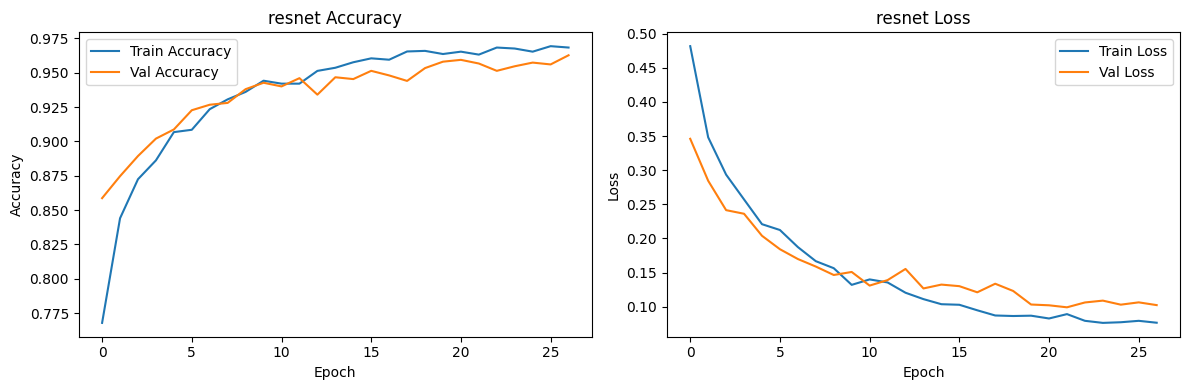

AUC: 0.9923


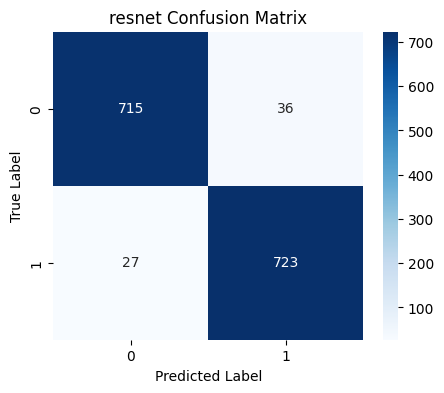


Experiment completed. Results saved to model_results.csv


In [8]:
if __name__ == "__main__":
    print("Experiment started at:", time.ctime())
    # run_cnn_experiment()
    run_resnet_experiment()

    print("\nExperiment completed. Results saved to", CSV_PATH)